# 1. Import libraries

In [1]:
#----------------------------Reproducible----------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import random as rn
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

#tf.set_random_seed(seed)
tf.compat.v1.set_random_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)
#----------------------------Reproducible----------------------------------------------------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#--------------------------------------------------------------------------------------------------------------------------------
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import plot_model

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import h5py
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
matplotlib.style.use('ggplot')

import pandas as pd
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sparse

#--------------------------------------------------------------------------------------------------------------------------------
#Import ourslef defined methods
import sys
sys.path.append(r"./Defined")
import Functions as F

# The following code should be added before the keras model
#np.random.seed(seed)

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# 2. Loading data

In [2]:
train_data_frame=np.array(pd.read_csv('./Dataset/isolet1+2+3+4.data',header=None))
test_data_frame=np.array(pd.read_csv('./Dataset/isolet5.data',header=None))

train_data_arr=(train_data_frame[:,0:617]).copy()
train_label_arr=((train_data_frame[:,617]).copy()-1)
test_data_arr=(test_data_frame[:,0:617]).copy()
test_label_arr=((test_data_frame[:,617]).copy()-1)

In [3]:
train_data_arr.shape

(6238, 617)

In [4]:
test_data_arr.shape

(1559, 617)

In [5]:
np.r_[train_data_arr,test_data_arr].shape

(7797, 617)

In [6]:
Data=MinMaxScaler(feature_range=(0,1)).fit_transform(np.r_[train_data_arr,test_data_arr])

In [7]:
Data.shape

(7797, 617)

In [8]:
C_train_x=Data[:len(train_data_arr)]
C_test_x=Data[len(train_data_arr):]
C_train_y=train_label_arr#to_categorical(train_label_arr)
C_test_y=test_label_arr#to_categorical(test_label_arr)

In [9]:
x_train,x_validate,y_train_onehot,y_validate_onehot= train_test_split(C_train_x,C_train_y,test_size=0.1,random_state=seed)
x_test=C_test_x
y_test_onehot=C_test_y

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_validate: ' + str(x_validate.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train_onehot.shape))
print('Shape of y_validate: ' + str(y_validate_onehot.shape))
print('Shape of y_test: ' + str(y_test_onehot.shape))

print('Shape of C_train_x: ' + str(C_train_x.shape)) 
print('Shape of C_train_y: ' + str(C_train_y.shape)) 
print('Shape of C_test_x: ' + str(C_test_x.shape)) 
print('Shape of C_test_y: ' + str(C_test_y.shape)) 

Shape of x_train: (5614, 617)
Shape of x_validate: (624, 617)
Shape of x_test: (1559, 617)
Shape of y_train: (5614,)
Shape of y_validate: (624,)
Shape of y_test: (1559,)
Shape of C_train_x: (6238, 617)
Shape of C_train_y: (6238,)
Shape of C_test_x: (1559, 617)
Shape of C_test_y: (1559,)


In [10]:
key_feture_number=55

# 3.Model

In [11]:
np.random.seed(seed)

#--------------------------------------------------------------------------------------------------------------------------------
class Feature_Select_Layer(Layer):
    
    def __init__(self, output_dim, **kwargs):
        super(Feature_Select_Layer, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',  
                                      shape=(input_shape[1],),
                                      initializer=initializers.RandomUniform(minval=0.999999, maxval=0.9999999, seed=seed),
                                      trainable=True)
        super(Feature_Select_Layer, self).build(input_shape)
    
    def call(self, x, selection=False,k=key_feture_number):
        kernel=K.abs(self.kernel)      
        if selection:
            kernel_=K.transpose(kernel)
            kth_largest = tf.math.top_k(kernel_, k=k)[0][-1]
            kernel = tf.where(condition=K.less(kernel,kth_largest),x=K.zeros_like(kernel),y=kernel)        
        return K.dot(x, tf.linalg.tensor_diag(kernel))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

#--------------------------------------------------------------------------------------------------------------------------------
def Autoencoder(p_data_feature=x_train.shape[1],\
                p_encoding_dim=key_feture_number,\
                p_learning_rate= 1E-3):
    input_img = Input(shape=(p_data_feature,), name='input_img')

    encoded = Dense(p_encoding_dim, activation='linear',kernel_initializer=initializers.glorot_uniform(seed))(input_img)
    bottleneck=encoded
    decoded = Dense(p_data_feature, activation='linear',kernel_initializer=initializers.glorot_uniform(seed))(encoded)

    latent_encoder = Model(input_img, bottleneck)
    autoencoder = Model(input_img, decoded)
    
    autoencoder.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    #print('Latent Encoder Structure-------------------------------------')
    #latent_encoder.summary()
    return autoencoder,latent_encoder

#--------------------------------------------------------------------------------------------------------------------------------
def Identity_Autoencoder(p_data_feature=x_train.shape[1],\
                         p_encoding_dim=key_feture_number,\
                         p_learning_rate= 1E-3):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)

    encoded = Dense(p_encoding_dim,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    
    bottleneck_score=encoded_score
    
    decoded = Dense(p_data_feature,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)

    latent_encoder_score = Model(input_img, bottleneck_score)
    autoencoder = Model(input_img, decoded_score)
    
    autoencoder.compile(loss='mean_squared_error',\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,latent_encoder_score

#--------------------------------------------------------------------------------------------------------------------------------
def Fractal_Autoencoder(p_data_feature=x_train.shape[1],\
                        p_feture_number=key_feture_number,\
                        p_encoding_dim=key_feture_number,\
                        p_learning_rate=1E-3,\
                        p_loss_weight_1=1,\
                        p_loss_weight_2=2):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)
    feature_selection_choose=feature_selection(input_img,selection=True,k=p_feture_number)

    encoded = Dense(p_encoding_dim,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    encoded_choose=encoded(feature_selection_choose)
    
    bottleneck_score=encoded_score
    bottleneck_choose=encoded_choose
    
    decoded = Dense(p_data_feature,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)
    decoded_choose =decoded(bottleneck_choose)

    latent_encoder_score = Model(input_img, bottleneck_score)
    latent_encoder_choose = Model(input_img, bottleneck_choose)
    feature_selection_output=Model(input_img,feature_selection_choose)
    autoencoder = Model(input_img, [decoded_score,decoded_choose])
    
    autoencoder.compile(loss=['mean_squared_error','mean_squared_error'],\
                        loss_weights=[p_loss_weight_1, p_loss_weight_2],\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,feature_selection_output,latent_encoder_score,latent_encoder_choose

## 3.1 Structure and paramter testing

In [12]:
epochs_number=200
batch_size_value=64

---
### 3.1.1 Fractal Autoencoder
---

In [13]:
loss_weight_1=0.0078125
F_AE,\
feature_selection_output,\
latent_encoder_score_F_AE,\
latent_encoder_choose_F_AE=Fractal_Autoencoder(p_data_feature=x_train.shape[1],\
                                               p_feture_number=key_feture_number,\
                                               p_encoding_dim=key_feture_number,\
                                               p_learning_rate= 1E-3,\
                                               p_loss_weight_1=loss_weight_1,\
                                               p_loss_weight_2=1)

#file_name="./log/F_AE_"+str(key_feture_number)+".png"
#plot_model(F_AE, to_file=file_name,show_shapes=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Autoencoder Structure-------------------------------------
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
autoencoder_input (InputLayer)  (None, 617)          0                                            
__________________________________________________________________________________________________
feature_selection (Feature_Sele (None, 617)          617         autoencoder_input[0][0]          
                                                                 autoencoder_input[0][0]          
__________________________________________________________________________________________________
autoencoder_hidden_layer (Dense (None, 55)           33990       feature_selection[0][0]          
                                  

In [14]:
model_checkpoint=ModelCheckpoint('./log_weights/F_AE_'+str(key_feture_number)+'_weights_'+str(loss_weight_1)+'.{epoch:04d}.hdf5',period=100,save_weights_only=True,verbose=1)
#print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(F_AE.layers[1].get_weights()))

F_AE_history = F_AE.fit(x_train, [x_train,x_train],\
                        epochs=epochs_number,\
                        batch_size=batch_size_value,\
                        shuffle=True,\
                        validation_data=(x_validate, [x_validate,x_validate]),\
                        callbacks=[model_checkpoint])



Train on 5614 samples, validate on 624 samples
Epoch 1/200
5614/5614 [==============================] - 2s 356us/step - loss: 0.0913 - autoencoder_output_loss: 0.0905 - val_loss: 0.0450 - val_autoencoder_output_loss: 0.0446
Epoch 2/200
5614/5614 [==============================] - 1s 213us/step - loss: 0.0392 - autoencoder_output_loss: 0.0388 - val_loss: 0.0355 - val_autoencoder_output_loss: 0.0352
Epoch 3/200
5614/5614 [==============================] - 1s 191us/step - loss: 0.0335 - autoencoder_output_loss: 0.0332 - val_loss: 0.0319 - val_autoencoder_output_loss: 0.0316
Epoch 4/200
5614/5614 [==============================] - 1s 217us/step - loss: 0.0303 - autoencoder_output_loss: 0.0300 - val_loss: 0.0287 - val_autoencoder_output_loss: 0.0285
Epoch 5/200
5614/5614 [==============================] - 1s 221us/step - loss: 0.0275 - autoencoder_output_loss: 0.0273 - val_loss: 0.0263 - val_autoencoder_output_loss: 0.0261
Epoch 6/200
5614/5614 [==============================] - 1s 238us/

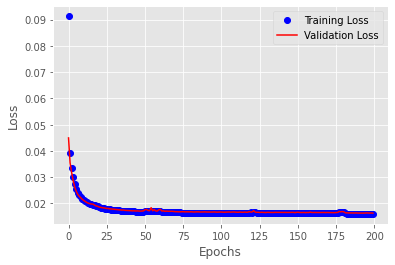

In [15]:
loss = F_AE_history.history['loss']
val_loss = F_AE_history.history['val_loss']

epochs = range(epochs_number)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

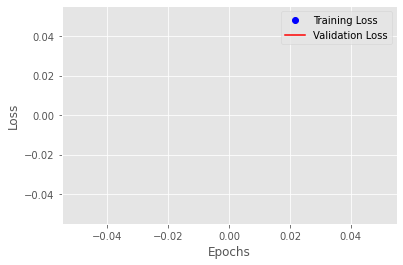

In [16]:
plt.plot(epochs[250:], loss[250:], 'bo', label='Training Loss')
plt.plot(epochs[250:], val_loss[250:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
p_data=F_AE.predict(x_test)
numbers=x_test.shape[0]*x_test.shape[1]

print("MSE for one-to-one map layer",np.sum(np.power(np.array(p_data)[0]-x_test,2))/numbers)
print("MSE for feature selection layer",np.sum(np.power(np.array(p_data)[1]-x_test,2))/numbers)

MSE for one-to-one map layer 0.012481887654907863
MSE for feature selection layer 0.016467067122346243


---
### 3.1.2 Feature selection layer output
---

In [18]:
FS_layer_output=feature_selection_output.predict(x_test)
print(np.sum(FS_layer_output[0]>0))

46


---
### 3.1.3 Key features show
---

In [19]:
key_features=F.top_k_keepWeights_1(F_AE.get_layer(index=1).get_weights()[0],key_feture_number)
print(np.sum(F_AE.get_layer(index=1).get_weights()[0]>0))

617


# 4 Classifying

### 4.1 Extra Trees

In [20]:
train_feature=C_train_x
train_label=C_train_y
test_feature=C_test_x
test_label=C_test_y
p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.9448364336112893
Testing accuracy： 0.9448364336112893


In [21]:
selected_position_list=np.where(key_features>0)[0]

---
#### 4.1.1. On Identity Selection layer
---

a) with zeros

In [22]:
train_feature=feature_selection_output.predict(C_train_x)
print("train_feature>0: ",np.sum(train_feature[0]>0))
print(train_feature.shape)
train_label=C_train_y
test_feature=feature_selection_output.predict(C_test_x)
print("test_feature>0: ",np.sum(test_feature[0]>0))
print(test_feature.shape)
test_label=C_test_y
p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

train_feature>0:  44
(6238, 617)
test_feature>0:  46
(1559, 617)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.8011545862732521
Testing accuracy： 0.8011545862732521


---

b) Sparse matrix

In [23]:
train_feature=feature_selection_output.predict(C_train_x)
print(train_feature.shape)
train_label=C_train_y

test_feature=feature_selection_output.predict(C_test_x)
print(test_feature.shape)
test_label=C_test_y

train_feature_sparse=sparse.coo_matrix(train_feature)
test_feature_sparse=sparse.coo_matrix(test_feature)

p_seed=seed
F.ETree(train_feature_sparse,train_label,test_feature_sparse,test_label,p_seed)

(6238, 617)
(1559, 617)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.8011545862732521
Testing accuracy： 0.8011545862732521


---

c) Compression

In [24]:
train_feature_=feature_selection_output.predict(C_train_x)
train_feature=F.compress_zero(train_feature_,key_feture_number)
print(train_feature.shape)
train_label=C_train_y

test_feature_=feature_selection_output.predict(C_test_x)
test_feature=F.compress_zero(test_feature_,key_feture_number)
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6238, 55)
(1559, 55)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.7466324567030147
Testing accuracy： 0.7466324567030147


---

d) Compression with structure

In [25]:
train_feature_=feature_selection_output.predict(C_train_x)
train_feature=F.compress_zero_withkeystructure(train_feature_,selected_position_list)
print(train_feature.shape)
train_label=C_train_y

test_feature_=feature_selection_output.predict(C_test_x)
test_feature=F.compress_zero_withkeystructure(test_feature_,selected_position_list)
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6238, 55)
(1559, 55)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.8576010262989096
Testing accuracy： 0.8576010262989096


---
#### 4.1.2. On Original Selection
---

a) with zeros

In [26]:
train_feature=np.multiply(C_train_x, key_features)
print("train_feature>0: ",np.sum(train_feature[0]>0))
print(train_feature.shape)
train_label=C_train_y

test_feature=np.multiply(C_test_x, key_features)
print("test_feature>0: ",np.sum(test_feature[0]>0))
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

train_feature>0:  44
(6238, 617)
test_feature>0:  46
(1559, 617)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.8011545862732521
Testing accuracy： 0.8011545862732521


---

b) Sparse matrix

In [27]:
train_feature=np.multiply(C_train_x, key_features)
print(train_feature.shape)
train_label=C_train_y

test_feature=np.multiply(C_test_x, key_features)
print(test_feature.shape)
test_label=C_test_y

train_feature_sparse=sparse.coo_matrix(train_feature)
test_feature_sparse=sparse.coo_matrix(test_feature)

p_seed=seed
F.ETree(train_feature_sparse,train_label,test_feature_sparse,test_label,p_seed)

(6238, 617)
(1559, 617)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.8011545862732521
Testing accuracy： 0.8011545862732521


---

c) Compression

In [28]:
train_feature_=np.multiply(C_train_x, key_features)
train_feature=F.compress_zero(train_feature_,key_feture_number)
print(train_feature.shape)
train_label=C_train_y

test_feature_=np.multiply(C_test_x, key_features)
test_feature=F.compress_zero(test_feature_,key_feture_number)
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6238, 55)
(1559, 55)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.7581783194355356
Testing accuracy： 0.7581783194355356


---

d) Compression with structure

In [29]:
train_feature_=np.multiply(C_train_x, key_features)
train_feature=F.compress_zero_withkeystructure(train_feature_,selected_position_list)
print(train_feature.shape)
train_label=C_train_y

test_feature_=np.multiply(C_test_x, key_features)
test_feature=F.compress_zero_withkeystructure(test_feature_,selected_position_list)
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6238, 55)
(1559, 55)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.8576010262989096
Testing accuracy： 0.8576010262989096


---
#### 4.1.3. Latent space
---

In [30]:
train_feature=latent_encoder_score_F_AE.predict(C_train_x)
print(train_feature.shape)
train_label=C_train_y
test_feature=latent_encoder_score_F_AE.predict(C_test_x)
print(test_feature.shape)
test_label=C_test_y
p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6238, 55)
(1559, 55)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.8742783835792175
Testing accuracy： 0.8742783835792175


In [31]:
train_feature=latent_encoder_choose_F_AE.predict(C_train_x)
print(train_feature.shape)
train_label=C_train_y
test_feature=latent_encoder_choose_F_AE.predict(C_test_x)
print(test_feature.shape)
test_label=C_test_y
p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6238, 55)
(1559, 55)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.7915330339961514
Testing accuracy： 0.7915330339961514


# 6. Reconstruction loss

In [32]:
from sklearn.linear_model import LinearRegression

def mse_check(train, test):
    LR = LinearRegression(n_jobs = -1)
    LR.fit(train[0], train[1])
    MSELR = ((LR.predict(test[0]) - test[1]) ** 2).mean()
    return MSELR

In [33]:
train_feature_=np.multiply(C_train_x, key_features)
C_train_selected_x=F.compress_zero_withkeystructure(train_feature_,selected_position_list)
print(C_train_selected_x.shape)

test_feature_=np.multiply(C_test_x, key_features)
C_test_selected_x=F.compress_zero_withkeystructure(test_feature_,selected_position_list)
print(C_test_selected_x.shape)


train_feature_tuple=(C_train_selected_x,C_train_x)
test_feature_tuple=(C_test_selected_x,C_test_x)

reconstruction_loss=mse_check(train_feature_tuple, test_feature_tuple)
print(reconstruction_loss)

(6238, 55)
(1559, 55)
0.016304111055073983
